In [1]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats
from tqdm import tqdm
import pickle

from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
import os
import pandas as pd
from glob import glob
from collections import defaultdict
import numpy as np

# --- Load CSVs ---
train_df = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/train.csv')
wavelengths_df = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/wavelengths.csv')
train_star_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/train_star_info.csv')

# --- 1. Basic Train Set Stats ---
print("🪐 Number of training planets:", train_df.shape[0])
print("📈 Number of target labels (wavelengths):", train_df.shape[1] - 1)
print("🔬 Length of wavelength grid:", wavelengths_df.shape[0])

# --- 2. Target Stats (per flux column) ---
target_cols = [col for col in train_df.columns if col != 'planet_id']
flux_summary = train_df[target_cols].agg(['min', 'max', 'mean', 'std']).T
print("\n📊 Flux value summary (first 5 rows):")
print(flux_summary.head())

# --- 3. Unique Stars ---
if 'planet_id' in train_star_info.columns:
    num_stars = train_star_info.drop(columns='planet_id').drop_duplicates().shape[0]
else:
    num_stars = train_star_info.drop_duplicates().shape[0]
print("\n🌟 Number of unique stars in training:", num_stars)

# --- 4. Planets with Multiple Observations ---
obs_counts = defaultdict(int)
train_planets = os.listdir('/kaggle/input/ariel-data-challenge-2025/train')

for pid in train_planets:
    air_obs = glob(f"train/{pid}/AIRS-CH0_signal_*.parquet")
    obs_counts[pid] = len(air_obs)

multi_obs = {pid: count for pid, count in obs_counts.items() if count > 1}
print("\n🔁 Planets with multiple observations:", len(multi_obs))

# --- 5. Check Calibration File Coverage ---
missing_calibs = []
expected = {"dark", "dead", "flat", "linear_corr", "read"}

for pid in train_planets:
    for band in ["AIRS-CH0", "FGS1"]:
        calib_path = f"train/{pid}/{band}_calibration"
        calib_files = {os.path.splitext(f)[0] for f in os.listdir(calib_path)} if os.path.exists(calib_path) else set()
        missing = expected - calib_files
        if missing:
            missing_calibs.append((pid, band, missing))

print("\n🧪 Planets missing calibration files:", len(missing_calibs))
if missing_calibs:
    print("   Example:", missing_calibs[0])

# --- 6. Optional: Distribution of Observations Per Planet ---
obs_distribution = pd.Series(list(obs_counts.values())).value_counts().sort_index()
print("\n🗂 Observation count distribution per planet (AIR-CH0):")
print(obs_distribution)

# --- 7. Planet-Star Uniqueness Check ---
merged = pd.merge(train_df[['planet_id']], train_star_info, on='planet_id', how='left')
unique_links = merged[['planet_id'] + [col for col in train_star_info.columns if col != 'planet_id']].drop_duplicates()
print("\n🔗 Unique planet-star mappings:", unique_links.shape[0])

🪐 Number of training planets: 1100
📈 Number of target labels (wavelengths): 283
🔬 Length of wavelength grid: 1

📊 Flux value summary (first 5 rows):
           min       max      mean       std
wl_1  0.003654  0.079797  0.014609  0.010652
wl_2  0.003668  0.077146  0.014588  0.010579
wl_3  0.003668  0.077210  0.014583  0.010574
wl_4  0.003667  0.077020  0.014578  0.010568
wl_5  0.003667  0.076574  0.014573  0.010561

🌟 Number of unique stars in training: 1100

🔁 Planets with multiple observations: 0

🧪 Planets missing calibration files: 2200
   Example: ('1253730513', 'AIRS-CH0', {'dead', 'linear_corr', 'dark', 'read', 'flat'})

🗂 Observation count distribution per planet (AIR-CH0):
0    1100
Name: count, dtype: int64

🔗 Unique planet-star mappings: 1100


In [3]:
train_adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/adc_info.csv')
# test_adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/test_adc_info.csv',
#                            index_col='planet_id')
train_labels = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/train.csv',
                           index_col='planet_id')
wavelengths = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/wavelengths.csv')
axis_info = pd.read_parquet('/kaggle/input/ariel-data-challenge-2025/axis_info.parquet')

In [4]:
planet_id = 1010375142
f_signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2025/train/{planet_id}/FGS1_signal_0.parquet')
f_signal

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_1014,column_1015,column_1016,column_1017,column_1018,column_1019,column_1020,column_1021,column_1022,column_1023
0,433,446,448,439,435,438,431,445,445,437,...,432,440,438,447,438,443,432,434,431,444
1,450,432,446,442,440,445,438,442,436,445,...,437,441,436,439,446,438,437,436,438,448
2,432,432,434,444,444,444,443,430,447,436,...,440,439,443,435,439,441,444,440,435,443
3,436,430,428,435,443,434,438,431,437,438,...,445,436,427,440,436,433,438,424,440,428
4,434,432,440,437,442,444,437,440,435,444,...,446,440,439,445,444,433,434,439,451,430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134995,435,429,433,438,444,444,437,442,439,435,...,449,442,442,433,438,440,442,435,434,452
134996,433,443,445,426,439,441,440,438,434,434,...,433,441,441,438,429,436,437,438,452,432
134997,446,433,444,434,435,436,440,430,435,439,...,434,439,428,436,441,444,431,425,431,442
134998,440,440,431,425,444,441,445,438,447,438,...,441,435,439,442,439,438,435,441,444,433


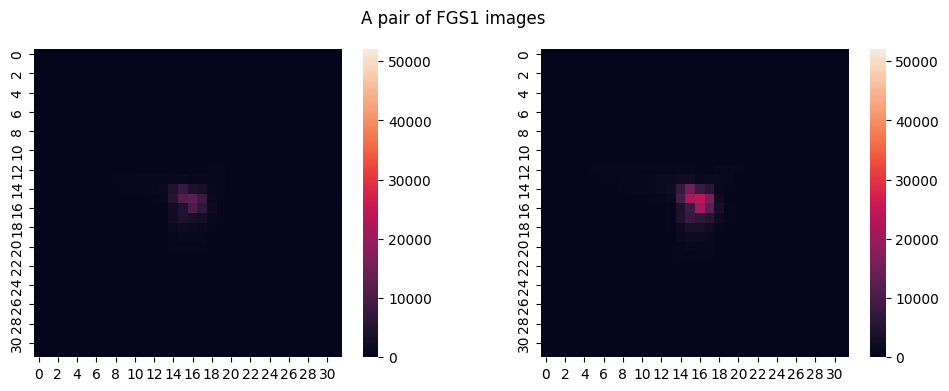

In [5]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(f_signal.iloc[0].values.reshape(32, 32), ax=ax1, vmin=0, vmax=52000)
ax1.set_aspect('equal')
sns.heatmap(f_signal.iloc[1].values.reshape(32, 32), ax=ax2, vmin=0, vmax=52000)
ax2.set_aspect('equal')
plt.suptitle('A pair of FGS1 images')
plt.show()

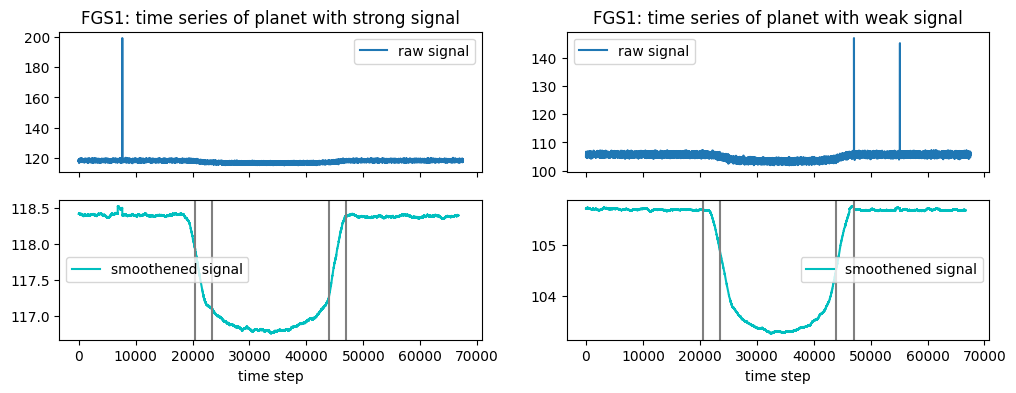

In [6]:
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, figsize=(12, 4))

planet_id = 1048114509
f_signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2025/train/{planet_id}/FGS1_signal_0.parquet')

mean_signal = f_signal.values.mean(axis=1)
net_signal = mean_signal[1::2] - mean_signal[0::2]
cum_signal = net_signal.cumsum()
window=800
smooth_signal = (cum_signal[window:] - cum_signal[:-window]) / window

ax1.set_title('FGS1: time series of planet with strong signal')
ax1.plot(net_signal, label='raw signal')
ax1.legend()
ax3.plot(smooth_signal, color='c', label='smoothened signal')
ax3.legend()
ax3.set_xlabel('time step')
for time_step in [20500, 23500, 44000, 47000]:
    ax3.axvline(time_step, color='gray')

planet_id = 1240764363
f_signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2025/train/{planet_id}/FGS1_signal_0.parquet')

mean_signal = f_signal.values.mean(axis=1)
net_signal = mean_signal[1::2] - mean_signal[0::2]
cum_signal = net_signal.cumsum()
window=800
smooth_signal = (cum_signal[window:] - cum_signal[:-window]) / window

ax2.set_title('FGS1: time series of planet with weak signal')
ax2.plot(net_signal, label='raw signal')
ax2.legend()
ax4.plot(smooth_signal, color='c', label='smoothened signal')
ax4.legend()
ax4.set_xlabel('time step')
for time_step in [20500, 23500, 44000, 47000]:
    ax4.axvline(time_step, color='gray')

# plt.suptitle('FGS1 time series', y=0.96)
plt.show()

In [7]:
planet_id = 1240764363
a_signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2025/train/{planet_id}/AIRS-CH0_signal_0.parquet')
a_signal

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_11382,column_11383,column_11384,column_11385,column_11386,column_11387,column_11388,column_11389,column_11390,column_11391
0,430,441,433,426,438,432,435,433,427,431,...,437,447,439,432,429,436,425,447,436,426
1,436,429,428,435,445,446,438,435,440,437,...,438,433,448,438,435,439,437,446,437,440
2,434,426,422,440,447,433,440,435,443,433,...,433,444,435,434,442,436,435,439,452,436
3,434,436,433,441,447,439,433,438,447,430,...,448,445,428,434,437,443,444,433,434,441
4,432,426,437,430,430,436,427,434,438,439,...,433,427,440,434,435,434,440,439,443,431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11245,437,435,441,437,447,427,448,435,436,438,...,449,438,437,445,436,447,443,442,441,436
11246,434,429,430,429,437,438,426,443,436,436,...,423,441,439,437,427,431,427,436,438,427
11247,439,428,449,440,440,434,433,437,443,437,...,430,442,436,449,433,448,452,439,435,439
11248,428,441,438,438,433,424,441,443,434,438,...,425,446,437,447,444,438,432,439,429,437


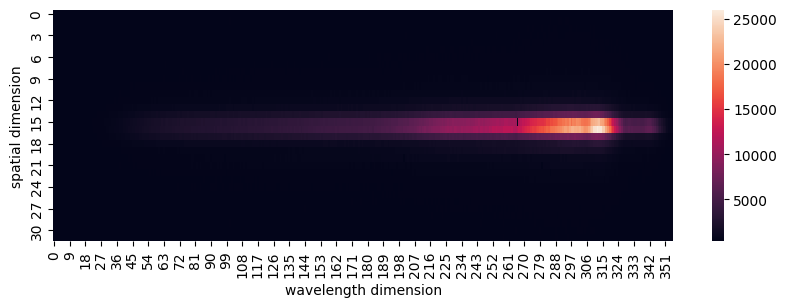

In [8]:
a_signal = a_signal.values.reshape(11250, 32, 356)

plt.figure(figsize=(10, 3))
sns.heatmap(a_signal[1])
plt.ylabel('spatial dimension')
plt.xlabel('wavelength dimension')
plt.show()

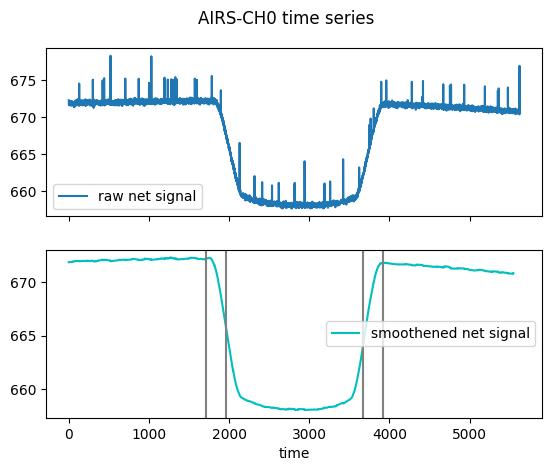

In [9]:
mean_signal = a_signal.mean(axis=2).mean(axis=1)
net_signal = mean_signal[1::2] - mean_signal[0::2]
cum_signal = net_signal.cumsum()
window=80
smooth_signal = (cum_signal[window:] - cum_signal[:-window]) / window

_, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(net_signal, label='raw net signal')
ax1.legend()
ax2.plot(smooth_signal, color='c', label='smoothened net signal')
ax2.legend()
ax2.set_xlabel('time')
for time_step in [20500, 23500, 44000, 47000]:
    ax2.axvline(time_step * 11250 // 135000, color='gray')
plt.suptitle('AIRS-CH0 time series', y=0.96)
plt.show()

In [10]:
%%writefile f_read_and_preprocess.py

def f_read_and_preprocess(dataset, adc_info, planet_ids):
    """Read the FGS1 files for all planet_ids and extract the time series.
    
    Parameters
    dataset: 'train' or 'test'
    adc_info: metadata dataframe, either train_adc_info or test_adc_info
    planet_ids: list of planet ids
    
    Returns
    dataframe with one row per planet_id and 67500 values per row
    
    """
    f_raw_train = np.full((len(planet_ids), 67500), np.nan, dtype=np.float32)
    for i, planet_id in tqdm(list(enumerate(planet_ids))):
        f_signal = pl.read_parquet(f'/kaggle/input/ariel-data-challenge-2025/{dataset}/{planet_id}/FGS1_signal_0.parquet')
        mean_signal = f_signal.cast(pl.Int32).sum_horizontal().cast(pl.Float32).to_numpy() / 1024 # mean over the 32*32 pixels
        net_signal = mean_signal[1::2] - mean_signal[0::2]
        f_raw_train[i] = net_signal
    return f_raw_train
    

Writing f_read_and_preprocess.py


In [11]:
%%time
exec(open('f_read_and_preprocess.py', 'r').read())
f_raw_train = f_read_and_preprocess('train', train_adc_info, train_labels.index)
with open('f_raw_train.pickle', 'wb') as f:
    pickle.dump(f_raw_train, f)

100%|██████████| 1100/1100 [14:55<00:00,  1.23it/s]


CPU times: user 24min 7s, sys: 3min 46s, total: 27min 53s
Wall time: 14min 56s


In [12]:
planet_id = 1010375142
f_signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2025/train/{planet_id}/FGS1_signal_0.parquet')
f_signal

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_1014,column_1015,column_1016,column_1017,column_1018,column_1019,column_1020,column_1021,column_1022,column_1023
0,433,446,448,439,435,438,431,445,445,437,...,432,440,438,447,438,443,432,434,431,444
1,450,432,446,442,440,445,438,442,436,445,...,437,441,436,439,446,438,437,436,438,448
2,432,432,434,444,444,444,443,430,447,436,...,440,439,443,435,439,441,444,440,435,443
3,436,430,428,435,443,434,438,431,437,438,...,445,436,427,440,436,433,438,424,440,428
4,434,432,440,437,442,444,437,440,435,444,...,446,440,439,445,444,433,434,439,451,430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134995,435,429,433,438,444,444,437,442,439,435,...,449,442,442,433,438,440,442,435,434,452
134996,433,443,445,426,439,441,440,438,434,434,...,433,441,441,438,429,436,437,438,452,432
134997,446,433,444,434,435,436,440,430,435,439,...,434,439,428,436,441,444,431,425,431,442
134998,440,440,431,425,444,441,445,438,447,438,...,441,435,439,442,439,438,435,441,444,433


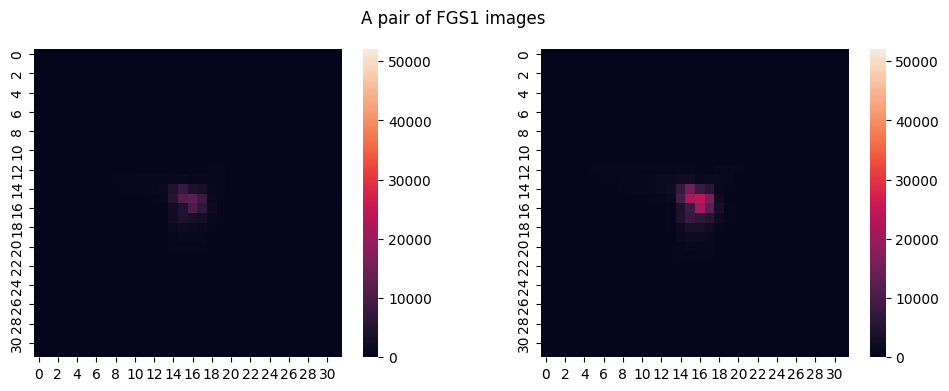

In [13]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(f_signal.iloc[0].values.reshape(32, 32), ax=ax1, vmin=0, vmax=52000)
ax1.set_aspect('equal')
sns.heatmap(f_signal.iloc[1].values.reshape(32, 32), ax=ax2, vmin=0, vmax=52000)
ax2.set_aspect('equal')
plt.suptitle('A pair of FGS1 images')
plt.show()

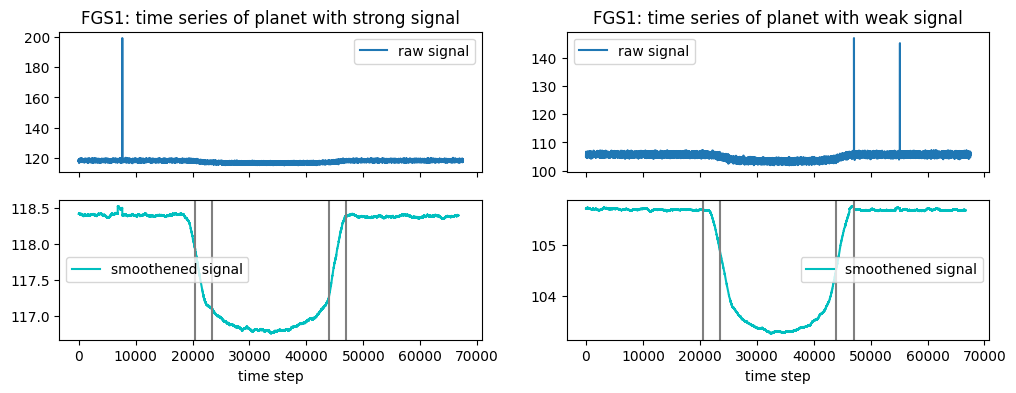

In [14]:
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, figsize=(12, 4))

planet_id = 1048114509
f_signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2025/train/{planet_id}/FGS1_signal_0.parquet')

mean_signal = f_signal.values.mean(axis=1)
net_signal = mean_signal[1::2] - mean_signal[0::2]
cum_signal = net_signal.cumsum()
window=800
smooth_signal = (cum_signal[window:] - cum_signal[:-window]) / window

ax1.set_title('FGS1: time series of planet with strong signal')
ax1.plot(net_signal, label='raw signal')
ax1.legend()
ax3.plot(smooth_signal, color='c', label='smoothened signal')
ax3.legend()
ax3.set_xlabel('time step')
for time_step in [20500, 23500, 44000, 47000]:
    ax3.axvline(time_step, color='gray')

planet_id = 1240764363
f_signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2025/train/{planet_id}/FGS1_signal_0.parquet')

mean_signal = f_signal.values.mean(axis=1)
net_signal = mean_signal[1::2] - mean_signal[0::2]
cum_signal = net_signal.cumsum()
window=800
smooth_signal = (cum_signal[window:] - cum_signal[:-window]) / window

ax2.set_title('FGS1: time series of planet with weak signal')
ax2.plot(net_signal, label='raw signal')
ax2.legend()
ax4.plot(smooth_signal, color='c', label='smoothened signal')
ax4.legend()
ax4.set_xlabel('time step')
for time_step in [20500, 23500, 44000, 47000]:
    ax4.axvline(time_step, color='gray')

# plt.suptitle('FGS1 time series', y=0.96)
plt.show()


In [15]:
planet_id = 1240764363
a_signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2025/train/{planet_id}/AIRS-CH0_signal_0.parquet')
a_signal

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_11382,column_11383,column_11384,column_11385,column_11386,column_11387,column_11388,column_11389,column_11390,column_11391
0,430,441,433,426,438,432,435,433,427,431,...,437,447,439,432,429,436,425,447,436,426
1,436,429,428,435,445,446,438,435,440,437,...,438,433,448,438,435,439,437,446,437,440
2,434,426,422,440,447,433,440,435,443,433,...,433,444,435,434,442,436,435,439,452,436
3,434,436,433,441,447,439,433,438,447,430,...,448,445,428,434,437,443,444,433,434,441
4,432,426,437,430,430,436,427,434,438,439,...,433,427,440,434,435,434,440,439,443,431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11245,437,435,441,437,447,427,448,435,436,438,...,449,438,437,445,436,447,443,442,441,436
11246,434,429,430,429,437,438,426,443,436,436,...,423,441,439,437,427,431,427,436,438,427
11247,439,428,449,440,440,434,433,437,443,437,...,430,442,436,449,433,448,452,439,435,439
11248,428,441,438,438,433,424,441,443,434,438,...,425,446,437,447,444,438,432,439,429,437


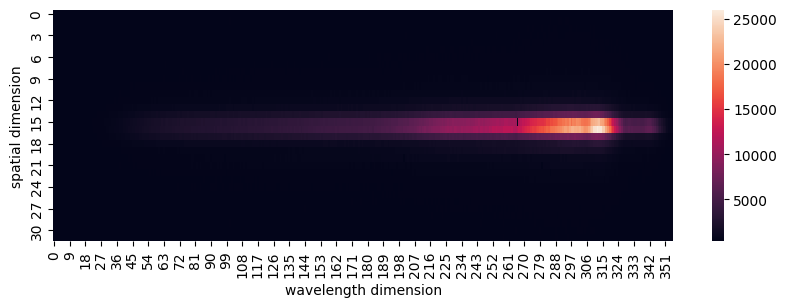

In [16]:
a_signal = a_signal.values.reshape(11250, 32, 356)

plt.figure(figsize=(10, 3))
sns.heatmap(a_signal[1])
plt.ylabel('spatial dimension')
plt.xlabel('wavelength dimension')
plt.show()

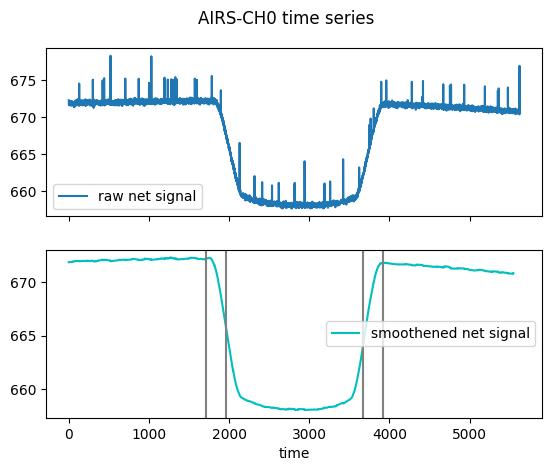

In [17]:
mean_signal = a_signal.mean(axis=2).mean(axis=1)
net_signal = mean_signal[1::2] - mean_signal[0::2]
cum_signal = net_signal.cumsum()
window=80
smooth_signal = (cum_signal[window:] - cum_signal[:-window]) / window

_, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(net_signal, label='raw net signal')
ax1.legend()
ax2.plot(smooth_signal, color='c', label='smoothened net signal')
ax2.legend()
ax2.set_xlabel('time')
for time_step in [20500, 23500, 44000, 47000]:
    ax2.axvline(time_step * 11250 // 135000, color='gray')
plt.suptitle('AIRS-CH0 time series', y=0.96)
plt.show()

In [18]:
%%writefile f_read_and_preprocess.py

def f_read_and_preprocess(dataset, adc_info, planet_ids):
    """Read the FGS1 files for all planet_ids and extract the time series.
    
    Parameters
    dataset: 'train' or 'test'
    adc_info: metadata dataframe, either train_adc_info or test_adc_info
    planet_ids: list of planet ids
    
    Returns
    dataframe with one row per planet_id and 67500 values per row
    
    """
    f_raw_train = np.full((len(planet_ids), 67500), np.nan, dtype=np.float32)
    for i, planet_id in tqdm(list(enumerate(planet_ids))):
        f_signal = pl.read_parquet(f'/kaggle/input/ariel-data-challenge-2025/{dataset}/{planet_id}/FGS1_signal_0.parquet')
        mean_signal = f_signal.cast(pl.Int32).sum_horizontal().cast(pl.Float32).to_numpy() / 1024 # mean over the 32*32 pixels
        net_signal = mean_signal[1::2] - mean_signal[0::2]
        f_raw_train[i] = net_signal
    return f_raw_train
    

Overwriting f_read_and_preprocess.py


In [19]:
%%time
exec(open('f_read_and_preprocess.py', 'r').read())
f_raw_train = f_read_and_preprocess('train', train_adc_info, train_labels.index)
with open('f_raw_train.pickle', 'wb') as f:
    pickle.dump(f_raw_train, f)

100%|██████████| 1100/1100 [13:55<00:00,  1.32it/s]


CPU times: user 24min 12s, sys: 3min 49s, total: 28min 1s
Wall time: 13min 56s


In [20]:
%%writefile a_read_and_preprocess.py
def a_read_and_preprocess(dataset, adc_info, planet_ids):
    """Read the AIRS-CH0 files for all planet_ids and extract the time series.
    
    Parameters
    dataset: 'train' or 'test'
    adc_info: metadata dataframe, either train_adc_info or test_adc_info
    planet_ids: list of planet ids
    
    Returns
    dataframe with one row per planet_id and 5625 values per row
    
    """
    a_raw_train = np.full((len(planet_ids), 5625), np.nan, dtype=np.float32)
    for i, planet_id in tqdm(list(enumerate(planet_ids))):
        signal = pl.read_parquet(f'/kaggle/input/ariel-data-challenge-2025/{dataset}/{planet_id}/AIRS-CH0_signal_0.parquet')
        mean_signal = signal.cast(pl.Int32).sum_horizontal().cast(pl.Float32).to_numpy() / (32*356) # mean over the 32*356 pixels
        net_signal = mean_signal[1::2] - mean_signal[0::2]
        a_raw_train[i] = net_signal
    return a_raw_train

Writing a_read_and_preprocess.py


In [21]:
%%time
exec(open('a_read_and_preprocess.py', 'r').read())
a_raw_train = a_read_and_preprocess('train', train_adc_info, train_labels.index)
with open('a_raw_train.pickle', 'wb') as f:
    pickle.dump(a_raw_train, f)

100%|██████████| 1100/1100 [15:27<00:00,  1.19it/s]

CPU times: user 28min 33s, sys: 2min 31s, total: 31min 4s
Wall time: 15min 27s


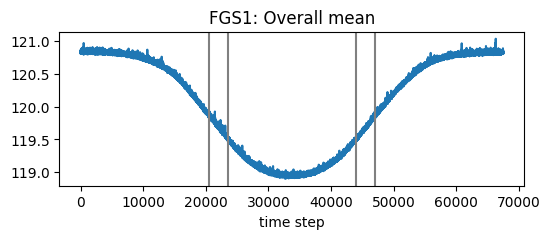

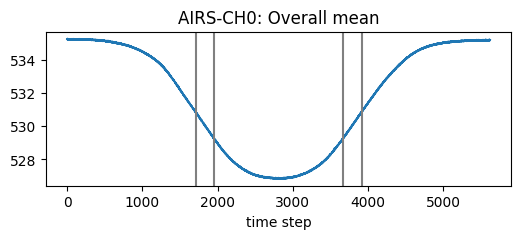

In [22]:
plt.figure(figsize=(6, 2))
plt.plot(f_raw_train.mean(axis=0))
for time_step in [20500, 23500, 44000, 47000]:
    plt.axvline(time_step, color='gray')
plt.xlabel('time step')
plt.title('FGS1: Overall mean')
plt.show()

plt.figure(figsize=(6, 2))
plt.plot(a_raw_train.mean(axis=0))
for time_step in [20500, 23500, 44000, 47000]:
    plt.axvline(time_step * 11250 // 135000, color='gray')
plt.xlabel('time step')
plt.title('AIRS-CH0: Overall mean')
plt.show()


In [23]:
%%writefile feature_engineering.py

def feature_engineering(f_raw, a_raw):
    """Create a dataframe with two features from the raw data.
    
    Parameters:
    f_raw: ndarray of shape (n_planets, 67500)
    a_raw: ndarray of shape (n_planets, 5625)
    
    Return value:
    df: DataFrame of shape (n_planets, 2)
    """
    obscured = f_raw[:, 23500:44000].mean(axis=1)
    unobscured = (f_raw[:, :20500].mean(axis=1) + f_raw[:, 47000:].mean(axis=1)) / 2
    f_relative_reduction = (unobscured - obscured) / unobscured
    obscured = a_raw[:, 1958:3666].mean(axis=1)
    unobscured = (a_raw[:, :1708].mean(axis=1) + a_raw[:, 3916:].mean(axis=1)) / 2
    a_relative_reduction = (unobscured - obscured) / unobscured

    df = pd.DataFrame({'a_relative_reduction': a_relative_reduction,
                       'f_relative_reduction': f_relative_reduction})
    
    return df

Writing feature_engineering.py


In [24]:
exec(open('feature_engineering.py', 'r').read())

train = feature_engineering(f_raw_train, a_raw_train)

In [25]:
model = Ridge(alpha=1e-12)

oof_pred = cross_val_predict(model, train, train_labels)

print(f"# R2 score: {r2_score(train_labels, oof_pred):.3f}")
sigma_pred = mean_squared_error(train_labels, oof_pred, squared=False)
print(f"# Root mean squared error: {sigma_pred:.6f}")
# R2 score: 0.971
# Root mean squared error: 0.000293

# R2 score: 0.929
# Root mean squared error: 0.002831


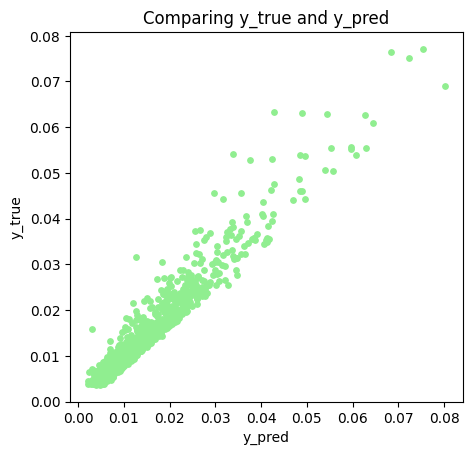

In [26]:
col = 1
plt.scatter(oof_pred[:,col], train_labels.iloc[:,col], s=15, c='lightgreen')
plt.gca().set_aspect('equal')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title('Comparing y_true and y_pred')
plt.show()

In [27]:
%%writefile competition_score.py
# Adapted from https://www.kaggle.com/code/metric/ariel-gaussian-log-likelihood

# Custom error for invalid submissions
class ParticipantVisibleError(Exception):
    pass

def competition_score(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    naive_mean: float,
    naive_sigma: float,
    sigma_true: float,
    row_id_column_name='planet_id'
) -> float:
    '''
    Computes a Gaussian Log Likelihood-based score.
    '''
    # Drop ID columns
    solution = solution.drop(columns=[row_id_column_name], errors='ignore')
    submission = submission.drop(columns=[row_id_column_name], errors='ignore')

    # Validation checks
    if submission.min().min() < 0:
        raise ParticipantVisibleError('Negative values in the submission')

    for col in submission.columns:
        if not pd.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be numeric: {col}')

    n_wavelengths = len(solution.columns)
    if len(submission.columns) != 2 * n_wavelengths:
        raise ParticipantVisibleError('Submission must have 2x columns of the solution')

    # Extract predictions and sigmas
    y_pred = submission.iloc[:, :n_wavelengths].values
    sigma_pred = np.clip(submission.iloc[:, n_wavelengths:].values, a_min=1e-15, a_max=None)
    y_true = solution.values

    # Compute log likelihoods
    GLL_pred = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_pred, scale=sigma_pred))
    GLL_true = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_true, scale=sigma_true))
    GLL_mean = np.sum(scipy.stats.norm.logpdf(y_true, loc=naive_mean, scale=naive_sigma))

    score = (GLL_pred - GLL_mean) / (GLL_true - GLL_mean)
    return float(np.clip(score, 0.0, 1.0))

Writing competition_score.py


In [28]:
def postprocessing(pred_array, index, sigma_pred, column_names=None):
    """
    Creates a submission DataFrame with mean predictions and uncertainties.

    Parameters:
    - pred_array: ndarray of shape (n_samples, 283)
    - index: pandas.Index of length n_samples
    - sigma_pred: float or ndarray of shape (n_samples, 283)
    - column_names: list of wavelength column names (optional)

    Returns:
    - df: DataFrame of shape (n_samples, 566)
    """
    n_samples, n_waves = pred_array.shape

    if column_names is None:
        column_names = [f"wl_{i+1}" for i in range(n_waves)]

    if np.isscalar(sigma_pred):
        sigma_pred = np.full_like(pred_array, sigma_pred)

    # Safety check
    assert sigma_pred.shape == pred_array.shape, "sigma_pred must match shape of pred_array"
    assert len(index) == n_samples, "Index length must match number of rows"

    df_mean = pd.DataFrame(pred_array.clip(0, None), index=index, columns=column_names)
    df_sigma = pd.DataFrame(sigma_pred, index=index, columns=[f"sigma_{i+1}" for i in range(n_waves)])

    return pd.concat([df_mean, df_sigma], axis=1)

In [29]:
exec(open('competition_score.py', 'r').read())
#exec(open('postprocessing.py', 'r').read())

oof_df = postprocessing(oof_pred, train_labels.index, sigma_pred)
display(oof_df)

gll_score = competition_score(train_labels.copy().reset_index(),
                              oof_df.copy().reset_index(),
                              naive_mean=train_labels.values.mean(),
                              naive_sigma=train_labels.values.std(),
                              sigma_true=0.000003)
print(f"# Estimated competition score: {gll_score:.3f}")
# Estimated competition score: 0.123

,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,wl_10,...,sigma_274,sigma_275,sigma_276,sigma_277,sigma_278,sigma_279,sigma_280,sigma_281,sigma_282,sigma_283
planet_id,,,,,,,,,,,,,,,,,,,,,
34983,0.021381,0.021378,0.021369,0.021360,0.021350,0.021339,0.021328,0.021317,0.021308,0.021300,...,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831
1873185,0.005107,0.005093,0.005094,0.005094,0.005095,0.005098,0.005104,0.005109,0.005113,0.005116,...,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831
3849793,0.049296,0.048420,0.048402,0.048372,0.048337,0.048294,0.048245,0.048199,0.048161,0.048129,...,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831
8456603,0.017049,0.017648,0.017637,0.017633,0.017631,0.017629,0.017627,0.017627,0.017627,0.017624,...,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831
23615382,0.015582,0.015574,0.015569,0.015563,0.015557,0.015551,0.015545,0.015541,0.015536,0.015532,...,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4290810553,0.024438,0.024321,0.024312,0.024300,0.024287,0.024271,0.024253,0.024237,0.024223,0.024210,...,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831
4291452525,0.021943,0.021114,0.021113,0.021100,0.021083,0.021063,0.021042,0.021022,0.021004,0.020990,...,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831
4291977477,0.007511,0.007675,0.007673,0.007672,0.007673,0.007676,0.007681,0.007687,0.007691,0.007693,...,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831,0.002831


# Estimated competition score: 0.153


In [30]:
# Refit the model to the full dataset
model.fit(train, train_labels)
with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)
with open('sigma_pred.pickle', 'wb') as f:
    pickle.dump(sigma_pred, f)

In [31]:
import pandas as pd
import numpy as np
import pickle

# 1. Load required files
test_adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/test_star_info.csv', index_col='planet_id')
sample_submission = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/sample_submission.csv', index_col='planet_id')
wavelengths = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/wavelengths.csv')

# 2. Load model and sigma
with open('model.pickle', 'rb') as f:
    model = pickle.load(f)

with open('sigma_pred.pickle', 'rb') as f:
    sigma_pred = pickle.load(f)

# 3. Run your preprocessing + feature extraction on test set
# These must be implemented in your own code — you can adapt from training logic
f_raw_test = f_read_and_preprocess('test', test_adc_info, sample_submission.index)
a_raw_test = a_read_and_preprocess('test', test_adc_info, sample_submission.index)
test_features = feature_engineering(f_raw_test, a_raw_test)

# 4. Predict
test_pred = model.predict(test_features)

# 5. Postprocessing
def postprocessing(pred_array, index, sigma_pred, column_names):
    """
    Convert predictions and uncertainty into final submission DataFrame.
    """
    if np.isscalar(sigma_pred):
        sigma_array = np.full_like(pred_array, sigma_pred)
    else:
        sigma_array = sigma_pred
    df_pred = pd.DataFrame(pred_array.clip(0, None), index=index, columns=column_names)
    df_sigma = pd.DataFrame(sigma_array, index=index, columns=[f"sigma_{i}" for i in range(1, len(column_names)+1)])
    return pd.concat([df_pred, df_sigma], axis=1)

submission_df = postprocessing(
    pred_array=test_pred,
    index=sample_submission.index,
    sigma_pred=sigma_pred,
    column_names=wavelengths.columns
)

# 6. Save
submission_df.to_csv('submission.csv')

# 7. Preview
!head submission.csv

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

planet_id,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,wl_10,wl_11,wl_12,wl_13,wl_14,wl_15,wl_16,wl_17,wl_18,wl_19,wl_20,wl_21,wl_22,wl_23,wl_24,wl_25,wl_26,wl_27,wl_28,wl_29,wl_30,wl_31,wl_32,wl_33,wl_34,wl_35,wl_36,wl_37,wl_38,wl_39,wl_40,wl_41,wl_42,wl_43,wl_44,wl_45,wl_46,wl_47,wl_48,wl_49,wl_50,wl_51,wl_52,wl_53,wl_54,wl_55,wl_56,wl_57,wl_58,wl_59,wl_60,wl_61,wl_62,wl_63,wl_64,wl_65,wl_66,wl_67,wl_68,wl_69,wl_70,wl_71,wl_72,wl_73,wl_74,wl_75,wl_76,wl_77,wl_78,wl_79,wl_80,wl_81,wl_82,wl_83,wl_84,wl_85,wl_86,wl_87,wl_88,wl_89,wl_90,wl_91,wl_92,wl_93,wl_94,wl_95,wl_96,wl_97,wl_98,wl_99,wl_100,wl_101,wl_102,wl_103,wl_104,wl_105,wl_106,wl_107,wl_108,wl_109,wl_110,wl_111,wl_112,wl_113,wl_114,wl_115,wl_116,wl_117,wl_118,wl_119,wl_120,wl_121,wl_122,wl_123,wl_124,wl_125,wl_126,wl_127,wl_128,wl_129,wl_130,wl_131,wl_132,wl_133,wl_134,wl_135,wl_136,wl_137,wl_138,wl_139,wl_140,wl_141,wl_142,wl_143,wl_144,wl_145,wl_146,wl_147,wl_148,wl_149,wl_150,wl_151,wl_152,wl_153,wl_154,wl_155,wl_156,wl_157